In [1]:
# utilities needed for data processing
import pandas as pd
import re
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection, naive_bayes, svm
import re
from sklearn.metrics import classification_report,confusion_matrix
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# utilities needed for models
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# we got readily available data
df = pd.read_csv("Twitter_AirlineSentiment.csv")
df.head()

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,568594180014014464,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)


In [3]:
# checking the dimensions of our data
print("No. of rows in dataset:",len(df))
print("No. of columns in dataset:",len(df.columns))

No. of rows in dataset: 10980
No. of columns in dataset: 12


In [4]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [5]:
# checking the baseline accuracy
# the accuracy of all the models we fit should be more than the baseline
(df['airline_sentiment'].value_counts()/len(df))*100

negative    62.395264
neutral     21.193078
positive    16.411658
Name: airline_sentiment, dtype: float64

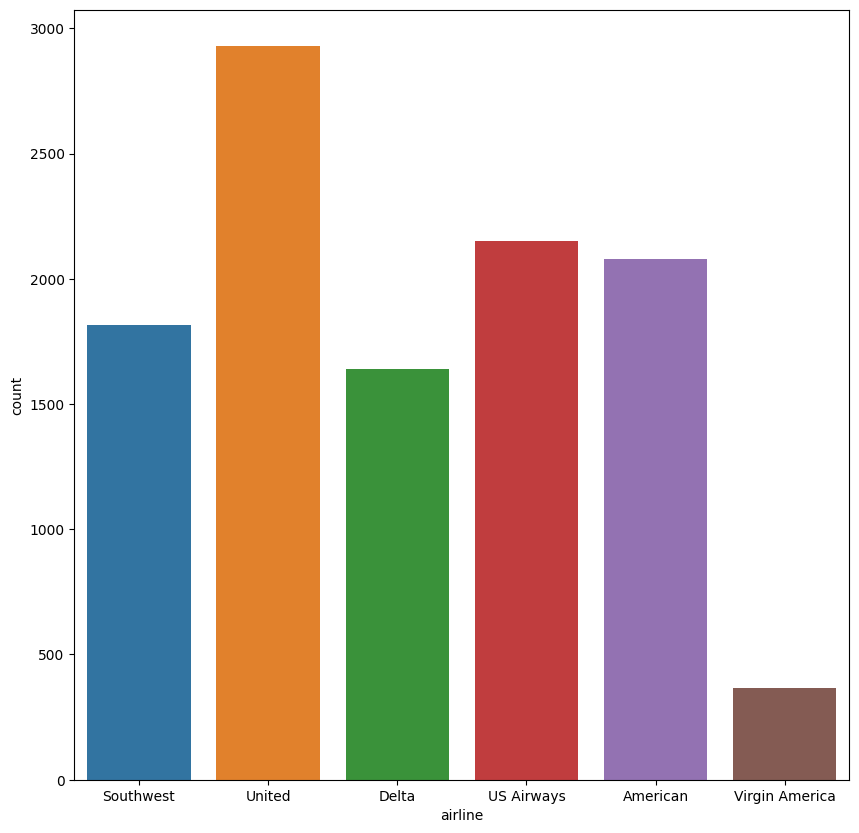

In [6]:
# plotting the unique values of airline
plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

# United has the highest number of tweets, while Virgin America has the least

Total number of tweets for each airline 
  airline
United            2928
US Airways        2152
American          2078
Southwest         1817
Delta             1639
Virgin America     366
Name: airline_sentiment, dtype: int64


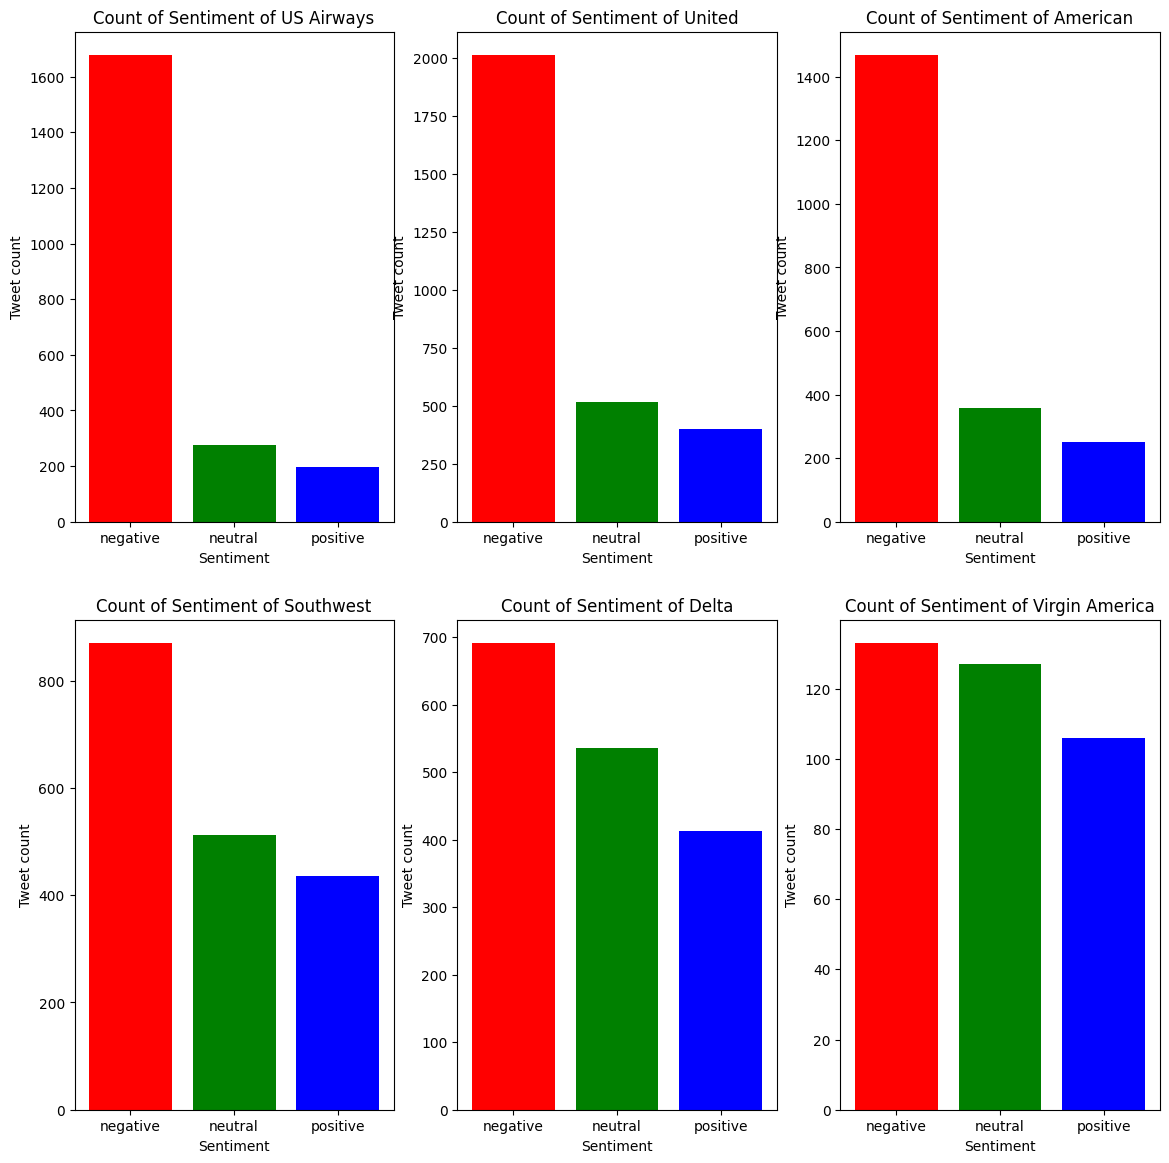

In [7]:
# data exploration - check the total tweets along with sentiments for each airline company
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(14, 14))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Tweet count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiment of '+i)

In [8]:
# function for data pre-processing : cleaning the tweets to get only the text values
def clean_tweet(text):
    tokens = nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
    tokens = [token.lower() for token in tokens]
    return ' '.join(tokens[2:])

In [9]:
# function for removing punctuation from the tweets
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [10]:
# finding the best model using grid search - using ROC AUC
def grid_search(model, parameters, x_train, y_train):
    # the grid will interate through the parameters and return the best ones to use
    grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
    # Fitting the grid 
    grid.fit(x_train,y_train)
    print()
    print()
    
    # Best model found using grid search
    optimal_model = grid.best_estimator_
    print('Best parameters are: ')
    print( grid.best_params_)
    
    # the values returned should be passed as parameters into our model
    return optimal_model

In [11]:
# checking accuracy of the models
# using ROC AUC and accuracy to check the model fit

def check_scores(clf,X_train, X_test, y_train, y_test):
    model=clf.fit(x_train, y_train)
    predicted_class=model.predict(x_test)
    predicted_class_train = model.predict(x_train)
    test_probs = model.predict_proba(x_test)
    test_probs = test_probs[:, 1]
    yhat = model.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    print('Train confusion matrix is: ',)
    print(confusion_matrix(y_train, predicted_class_train))

    print()
    print('Test confusion matrix is: ')
    print(confusion_matrix(y_test, predicted_class))
    print()
    print(classification_report(y_test,predicted_class)) 
    print() 
    train_accuracy = accuracy_score(y_train,predicted_class_train)
    test_accuracy = accuracy_score(y_test,predicted_class)

    print("Train accuracy score: ", train_accuracy)
    print("Test accuracy score: ",test_accuracy )
    print()
    train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
    test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

    print("Train ROC-AUC score: ", train_auc)
    print("Test ROC-AUC score: ", test_auc)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(lr_recall, lr_precision)
    ax1.set(xlabel="Recall", ylabel="Precision")

    plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    print()
    print('Area under the Precision-Recall curve:', lr_f1)

    fpr, tpr, _ = roc_curve(y_test, test_probs)
    
    ax2.plot(fpr, tpr)
    ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

    print("Area under ROC-AUC:", lr_auc)
    return train_accuracy, test_accuracy, train_auc, test_auc

In [12]:
# removing neutral tweets - unnecessary considering they are not really affecting the model
# Positive and Negative are the main 2 classes we will use

df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,567900433542488064,0,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada),am scheduled for the morning days after the fa...
1,569989168903819264,1,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada),your workers time in and time out going above ...
2,568089179520954368,1,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada),ord to miami and back and had great crew servi...
3,568928195581513728,0,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada),that s horse radish
4,568594180014014464,0,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada),our flight into ord was delayed because of air...


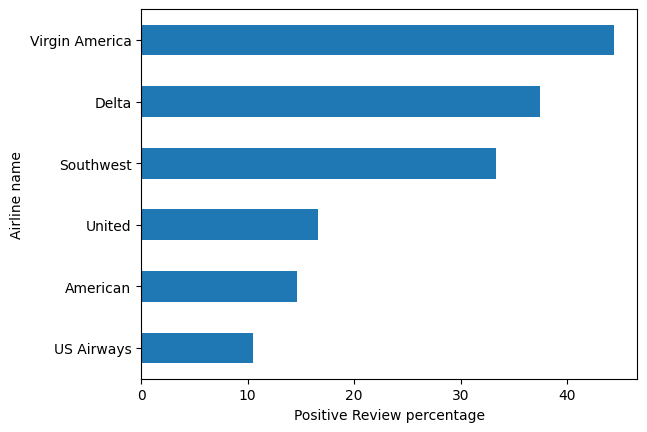

In [13]:
# plot the positive review percentage of each airline company
# we can understand who has the maximum customer satisfaction

df2 = df.copy()
df2["Count"]=1
df2 = df2.groupby('airline')[["airline_sentiment", "Count"]].sum()
df2["Positive Review %"]= (df2["airline_sentiment"]/df2["Count"])*100
df2["Positive Review %"].sort_values().plot(kind='barh')

plt.xlabel("Positive Review percentage")
plt.ylabel("Airline name")
plt.show()

In [14]:
# Cleaning the tweets, removing punctuation marks
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,567900433542488064,0,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada),scheduled morning days fact yes sure evening f...
1,569989168903819264,1,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada),workers time time going beyond love flying guy...
2,568089179520954368,1,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada),ord miami back great crew service legs thanks
3,568928195581513728,0,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada),horse radish
4,568594180014014464,0,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada),flight ord delayed air force one last flight s...


In [15]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array([0, 1], dtype=int64)

In [16]:
# Training data
x_train_data = df["text"]
y_train_data = df["airline_sentiment"]

In [17]:
# Importing stopwords
from nltk.corpus import stopwords
stop = stopwords.words("english")

# Importing punctuations
import string
punctuations = string.punctuation

# Adding Punctuations to our stop words
stop += punctuations

In [18]:
# Splitting in the given training data for our training and testing in a ratio of 75:25
from sklearn.model_selection import train_test_split

# transforming dataset using Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
tf_idf_vec = vectorizer.fit_transform(df.cleaned_tweet)

# splitting the train and test data in a 75:25 ratio
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vec, df['airline_sentiment'], random_state = 597, test_size = 0.25,
                                                   stratify=df["airline_sentiment"])

In [19]:
# Tuning the hyperparameters for SVC
# the best parameters we get will be passed into the final SVC model
parameters ={
    "C":[10,100,1000],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']
}

svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   2.6s
[CV] END ...................C=10, gamma=scale, kernel=linear; total time=   3.3s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   4.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   4.6s
[CV] END ..................C=10, gamma=scale, kernel=sigmoid; total time=   2.6s
[CV] END ..................C=10, gamma=scale, kernel=sigmoid; total time=   2.6s
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   2.7s
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=   3.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   2.4s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   2.4s
[CV] END ...................C=10, gamma=auto, kernel=sigmoid; total time=   1.9s
[CV] END ...................C=10, gamma=auto, ke

Train confusion matrix is: 
[[5116   22]
 [   1 1350]]

Test confusion matrix is: 
[[1677   36]
 [ 185  266]]

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1713
           1       0.88      0.59      0.71       451

    accuracy                           0.90      2164
   macro avg       0.89      0.78      0.82      2164
weighted avg       0.90      0.90      0.89      2164


Train accuracy score:  0.9964555401448605
Test accuracy score:  0.8978743068391867

Train ROC-AUC score:  0.9983768492926106
Test ROC-AUC score:  0.9324372251842244

Area under the Precision-Recall curve: 0.7065073041168659
Area under ROC-AUC: 0.8341676753099752


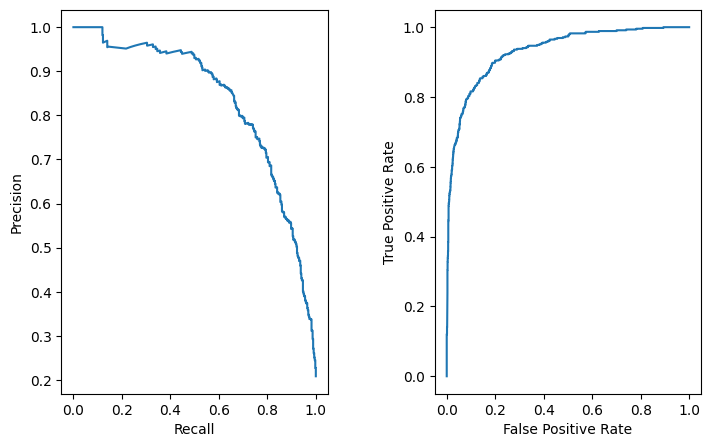

In [20]:
## Base SVM model

SVM = svm.SVC(probability=True,gamma='scale', C=100, kernel='rbf')
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM, x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[5137    1]
 [ 998  353]]

Test confusion matrix is: 
[[1710    3]
 [ 377   74]]

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1713
           1       0.96      0.16      0.28       451

    accuracy                           0.82      2164
   macro avg       0.89      0.58      0.59      2164
weighted avg       0.85      0.82      0.77      2164


Train accuracy score:  0.8460471567267683
Test accuracy score:  0.8243992606284658

Train ROC-AUC score:  0.9589154293389928
Test ROC-AUC score:  0.8974310185706538

Area under the Precision-Recall curve: 0.2803030303030303
Area under ROC-AUC: 0.7305663986147978


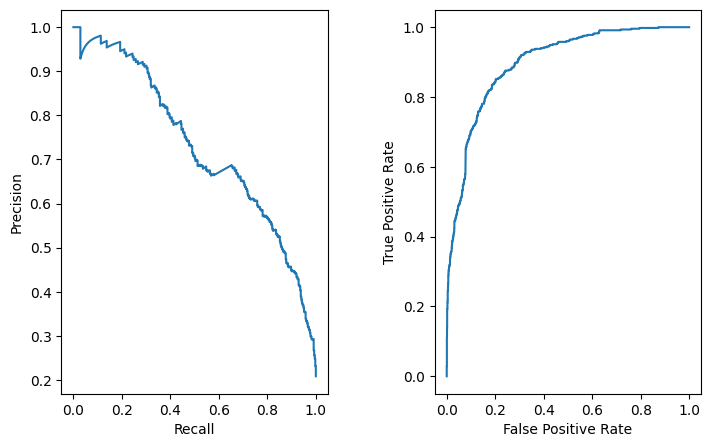

In [21]:
## Multinomial Naive Bayes model

from sklearn.naive_bayes import MultinomialNB
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)

Train confusion matrix is: 
[[5111   27]
 [ 677  674]]

Test confusion matrix is: 
[[1697   16]
 [ 275  176]]

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1713
           1       0.92      0.39      0.55       451

    accuracy                           0.87      2164
   macro avg       0.89      0.69      0.73      2164
weighted avg       0.87      0.87      0.84      2164


Train accuracy score:  0.8915087070426876
Test accuracy score:  0.8655268022181146

Train ROC-AUC score:  0.9744852579537554
Test ROC-AUC score:  0.9283916004261141

Area under the Precision-Recall curve: 0.547433903576983
Area under ROC-AUC: 0.809350974436677


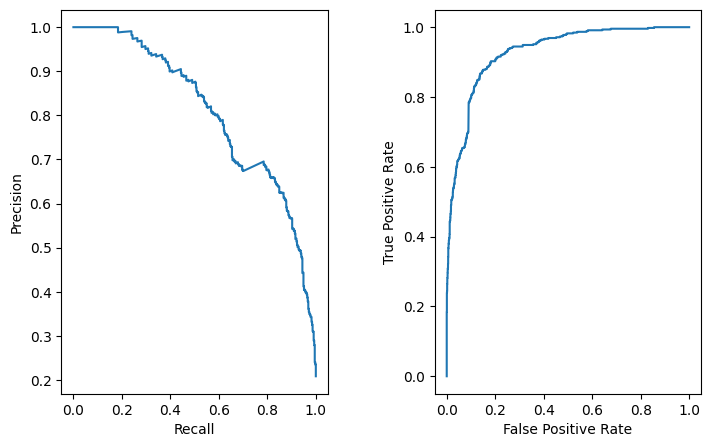

In [22]:
## Logistic Regression model

from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state=0)
l_train_accuracy, l_test_accuracy, l_train_auc, l_test_auc = check_scores(LogReg, x_train, x_test, y_train, y_test)

In [23]:
## Random Forest model - tuning the hyperparameters

from sklearn.ensemble import RandomForestClassifier

# Tuning the hyperparameters for Random Forest
# the best parameters we get will be passed into the final RandomForest model
parameters ={
    "n_estimators":[100,200,500],
    "max_features":['sqrt',50,60,75]
}

rf_optimal = grid_search(RandomForestClassifier(random_state=0), parameters, x_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ................max_features=sqrt, n_estimators=100; total time=   6.9s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   7.3s
[CV] END ................max_features=sqrt, n_estimators=200; total time=  13.5s
[CV] END ................max_features=sqrt, n_estimators=200; total time=  14.6s
[CV] END ................max_features=sqrt, n_estimators=500; total time=  33.9s
[CV] END ................max_features=sqrt, n_estimators=500; total time=  35.9s
[CV] END ..................max_features=50, n_estimators=100; total time=   6.5s
[CV] END ..................max_features=50, n_estimators=100; total time=   7.1s
[CV] END ..................max_features=50, n_estimators=200; total time=  13.4s
[CV] END ..................max_features=50, n_estimators=200; total time=  14.5s


In [ ]:
## running the RF model
RanForest = RandomForestClassifier(n_estimators=500, max_features=50,random_state=0)
rf_train_accuracy, rf_test_accuracy, rf_train_auc, rf_test_auc = check_scores(RanForest, x_train, x_test, y_train, y_test)